# Setup
## Import required packages

In [7]:
import math
import sqlite3
import struct
import datetime
import scipy.fftpack
from scipy import signal as sig
from scipy import optimize as opt

import matplotlib
from matplotlib import pyplot as plt
from matplotlib import patches
import numpy as np
from scipy import signal, optimize
from tqdm.notebook import tnrange, tqdm
from IPython.display import set_matplotlib_formats

In [2]:
%matplotlib inline
set_matplotlib_formats('png', 'pdf')

## Load data series information from sqlite capture file

One capture file may contain multiple runs/data series. Display a list of runs and their start/end time and sample count, then select the newest one in `last_run` variable.

In [3]:
db = sqlite3.connect('data/waveform_1pps_debug.sqlite3')

In [4]:
for run_id, start, end, count in db.execute('SELECT run_id, MIN(rx_ts), MAX(rx_ts), COUNT(*) FROM measurements GROUP BY run_id'):
    foo = lambda x: datetime.datetime.fromtimestamp(x/1000)
    start, end = foo(start), foo(end)
    print(f'Run {run_id:03d}: {start:%Y-%m-%d %H:%M:%S} - {end:%Y-%m-%d %H:%M:%S} ({str(end-start)[:-3]:>13}, {count*32:>9d}sp)')
last_run, n_records = run_id, count
sampling_rate = 1000.0

Run 000: 2020-03-31 16:58:00 - 2020-03-31 16:58:36 (  0:00:36.029,     36512sp)
Run 001: 2020-03-31 16:58:51 - 2020-03-31 17:05:19 (  0:06:27.729,    392608sp)
Run 002: 2020-03-31 17:07:02 - 2020-03-31 17:41:34 (  0:34:32.105,     37024sp)
Run 003: 2020-03-31 18:50:05 - 2020-03-31 18:50:43 (  0:00:37.576,     38048sp)
Run 004: 2020-03-31 18:54:08 - 2020-03-31 19:14:32 (  0:20:24.104,   1239424sp)


# Calculate period measurement histograms and convert to Hz

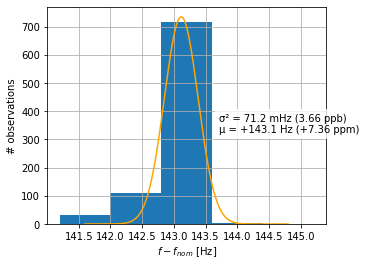

In [9]:
histogram = np.array(db.execute('SELECT gps_1pps, COUNT(*) FROM measurements WHERE gps_1pps != -1 AND run_id = ? GROUP BY gps_1pps', (last_run,)).fetchall())
hist_plot = histogram.astype(float)[1:-1]
hist_plot[:, 0] *= 2 / 5 * 2
hist_plot[:, 1] /= (1000 / 32)

f_nom = 19.440e6

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 10}
matplotlib.rc('font', **font)
fig, ax = plt.subplots(figsize=(5, 4))
ax.grid()
# We have a bug that causes our measurements to occassionally be out by +/- 65534 counts.
# For now, fix this by simply throwing away these (very obviously invalid) bins.
ax.bar(hist_plot[:,0] - f_nom , hist_plot[:, 1])

def gauss(x, *p):
    A, mu, sigma = p
    return A*np.exp(-(x-mu)**2/(2.*sigma**2))

gauss_x = np.linspace(np.min(hist_plot[:,0]), np.max(hist_plot[:,0]), 10000)
coeff, var_matrix = opt.curve_fit(gauss, hist_plot[:,0], hist_plot[:,1], p0=[np.max(hist_plot[:,1]), np.mean(hist_plot[:,0]), 1])
hist_fit = gauss(gauss_x, *coeff)
ax.plot(gauss_x - f_nom, hist_fit, color='orange')
_A, mu, sigma = coeff
bbox_props = dict(fc='white', alpha=0.8, ec='none')
ax.annotate(f'σ² = {sigma**2 * 1e3:.1f} mHz ({sigma**2 / f_nom * 1e9:.2f} ppb)\n'
            f'μ = {mu-f_nom:+.1f} Hz ({(mu-f_nom)/f_nom * 1e6:+.2f} ppm)',
            xy=[0.6, 0.5], xycoords='figure fraction', bbox=bbox_props)
ax.set_xlabel('$f - f_{nom}$ [Hz]')
ax.set_ylabel('# observations')

#ax.set_title('OCXO frequency derivation relative to GPS 1pps')
fig.savefig('fig_out/ocxo_freq_stability.pdf', format='pdf')